In [12]:
import sys

sys.path.append('../compare')

import numpy as np
import pickle
from scipy.io import savemat
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
from matplotlib.gridspec import GridSpec
from tqdm import tqdm
import pandas as pd
import os
from utils import returnFFT,returnPSD,ITR

In [19]:
srate = 250
expName = 'sweep'

dir = '../datasets/%s.pickle' % expName

with open(dir, "rb") as fp:
    wholeset = pickle.load(fp)

sub = wholeset[-3]
chnNames = ['PZ', 'PO5', 'POZ', 'PO4', 'PO6', 'O1', 'OZ','O2','PO3']
chnINX = [sub['channel'].index(i) for i in chnNames]
X = sub['wn']['X'][:,chnINX]
y = sub['wn']['y']
S = sub['wn']['STI']
sub['name']

'yangyuxing'

# Build EEG2Code model

## define parameter

In [20]:
winLEN=1
tmin = -0.5
tmax = 0
p=0.95
n_band=1
taus = np.arange(tmin,tmax+1/srate,1/srate)
ts = np.arange(0,winLEN,1/srate)

In [21]:
from modeling import Code2EEG,EEG2Code

model = EEG2Code(srate=srate,winLEN=winLEN,tmin=tmin,tmax=tmax,S=(S,np.unique(y)),estimator=p,padding=True,n_band=n_band,component=1)

model.fit(X,y)

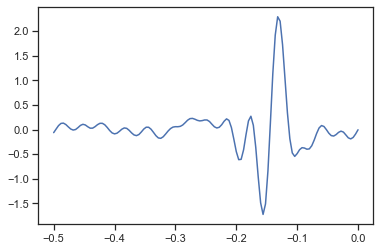

In [22]:
sns.set_theme(style='ticks')
plt.plot(taus,model.trf.T)

## predicts STI from response

In [23]:
sEst = model.predict(X)

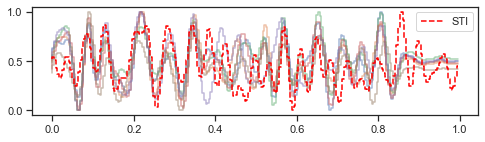

In [24]:
i=1
sns.set_theme(style='ticks')
f,ax =plt.subplots(figsize=(8,2))

ax.step(ts,sEst[y==i].T,alpha=0.5)
ax.step(ts,model.STI[np.unique(y)==i].T,color='red',linestyle='dashed',label='STI')
ax.legend()

# Lower bound

In [25]:
X = X-np.mean(X,axis=-1,keepdims=True)
X_ = X.mean(axis=1)
_class = np.unique(y)
X_.shape

(960, 250)

In [26]:
STI = np.concatenate([S[_class == i] for i in y])
sNoise = STI-sEst

In [27]:
f,ampS = returnFFT(STI,srate=250)
f, sEst_f = returnFFT(sEst, srate=250)
f, noise_f = returnFFT(sNoise, srate=250)
conj_sEst_f = np.conjugate(sEst_f)
conj_noise_f = np.conjugate(noise_f)

In [28]:
up = sEst_f*conj_sEst_f
down = noise_f*conj_noise_f
r = up.mean(axis=0)/down.mean(axis=0)
r[f>30] = 0

/Users/shinanlin/opt/anaconda3/envs/eelbrain/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


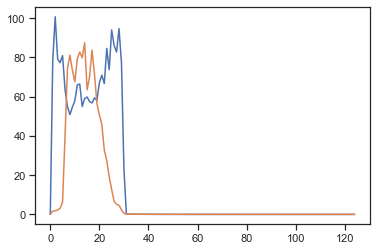

In [29]:
plt.plot(f,down.mean(axis=0))
plt.plot(f,up.mean(axis=0))

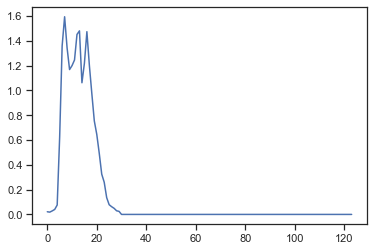

In [30]:
plt.plot(r[1:])

In [31]:
SNR1 = np.zeros_like(sEst_f)
SNR2 = np.zeros_like(sEst_f)

for j, (s, n, sc, nc) in enumerate(zip(sEst_f, noise_f, conj_sEst_f, conj_noise_f)):

    SNR1[j] = s*sc
    SNR2[j] = n*nc

SNR = SNR1.mean(axis=0)/SNR2.mean(axis=0)

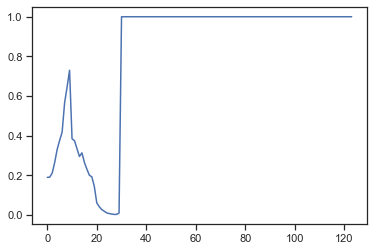

In [142]:
plt.plot(SNR[1:])

In [143]:
x = 1+np.square(SNR)

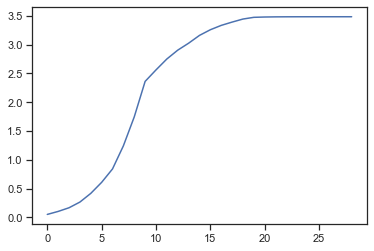

In [144]:
plt.plot(np.cumsum(np.log2(x[1:30])))

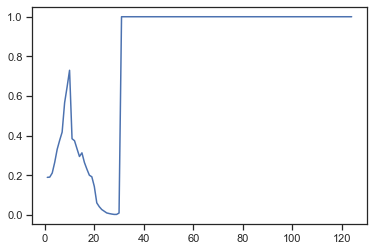

In [145]:
plt.plot(f[1:],SNR[1:])

In [32]:
xX = model.enhancer.transform(X)
xX = np.squeeze(xX)

In [15]:
f,ampR = returnFFT(xX,srate=250)
f,ampS = returnFFT(STI,srate=250)
conj_ampR = np.conjugate(ampR)

In [33]:
Hf = (conj_ampR*ampS).mean(axis=0)/(conj_ampR*ampR).mean(axis=0)

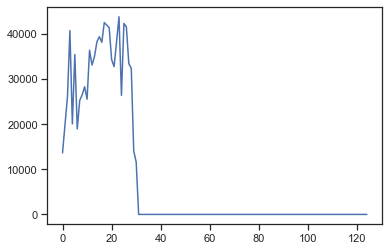

In [34]:
plt.plot(np.abs(Hf))

In [ ]:
x = ampR.mean(axis=0)[1:]

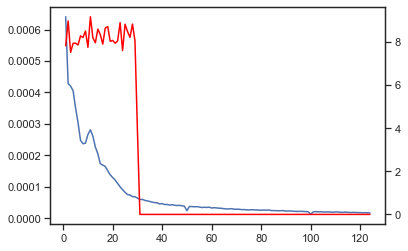

In [ ]:
sns.set_theme(style='ticks')
fig,ax = plt.subplots()
ax1 = ax.twinx()
ax.plot(f[1:],np.abs(ampR).mean(axis=0)[1:])
ax1.plot(f[1:],np.abs(ampS).mean(axis=0)[1:],color='red')

# Upper bound

In [30]:
evoked = np.squeeze(model.enhanced)
evoked = np.concatenate([evoked[np.unique(y)==i] for i in y])

enhanced = model.enhancer.transform(X)
enhanced = np.squeeze(enhanced)

noise = enhanced-evoked

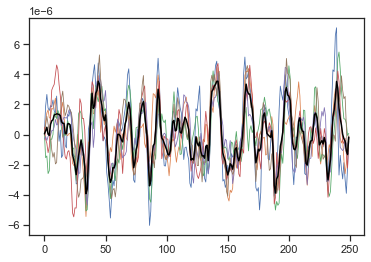

In [40]:
i=4
plt.plot(enhanced[y==i].T,linewidth=0.8)
plt.plot(evoked[y==i].mean(axis=0),color='black',linewidth=1.5)

In [ ]:
f,evoked_f = returnFFT(evoked,srate=250)
f,enhance_f = returnFFT(enhanced,srate=250)
f,noise_f = returnFFT(noise,srate=250)

In [ ]:
power_evoked = 1/125 * (np.abs(evoked_f))**2
power_noise = 1/125 * (np.abs(noise_f))**2

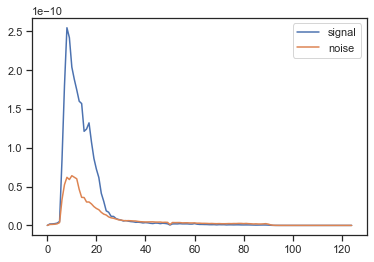

In [ ]:
plt.plot(f, power_evoked.mean(axis=0),label='signal')
plt.plot(f, power_noise.mean(axis=0),label='noise')
plt.legend()

In [ ]:
SNR = power_evoked.mean(axis=0)/power_noise.mean(axis=0)

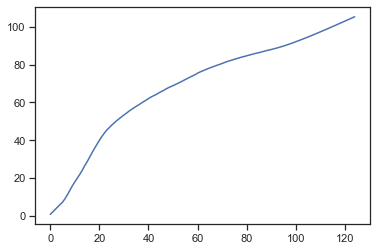

In [ ]:
plt.plot(np.cumsum(np.log2(1+SNR)))

In [ ]:
SNR = np.zeros_like(enhance_f)
for j, (e, n) in enumerate(zip(evoked_f, noise_f)):
    SNR[j] = e/n

In [ ]:
bbb = np.mean(evoked_f/noise_f,axis=0)

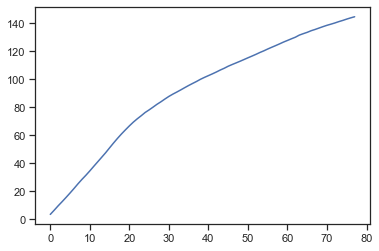

In [ ]:
plt.plot(np.cumsum(np.log2(1+bbb)))


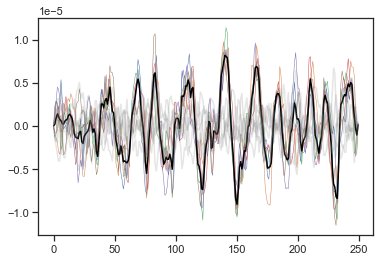

In [ ]:
i = 4

plt.plot(enhanced[y==i].T,linewidth=0.5)
plt.plot(evoked[y==i].mean(axis=0),linewidth=1.5,color='black')
plt.plot(noise[y == i].T, linewidth=1.5, color='gray',alpha=0.2)

# plot

In [13]:
capacity = []
add = '../results/sweep'
subs = os.listdir(add)

for sub in subs:
    subFolder = add+os.sep+sub
    if os.path.exists(subFolder+os.sep+'info.csv'):
        f = pd.read_csv(subFolder+os.sep+'info.csv')
        capacity.append(f)

capacity = pd.concat(capacity, ignore_index=True).drop_duplicates()
capacity = capacity[capacity.f>=1]
capacity.head()

,Unnamed: 0,f,lbSNR,lbrate,ubSNR,ubrate,SS,NN,sPower,nPower,Hf,X,STI,subject,ubINFO,lbINFO
1,1,1.0,0.045484,4.407927,3.608356,3.744740,3.632681,79.866942,7.170421e-12,1.987171e-12,4102.819114,9.157593e-12,7.822192,yangyuxing,158.572486,(25.56562933950198+0j)
2,2,2.0,0.102508,4.548717,3.122593,5.788292,10.298261,100.462583,2.646142e-11,8.474181e-12,14208.556955,3.493560e-11,8.975460,yangyuxing,158.572486,(25.56562933950198+0j)
3,3,3.0,0.213403,4.827775,4.172189,8.159067,16.469595,77.176203,4.298090e-11,1.030176e-11,21483.995688,5.328266e-11,7.518709,yangyuxing,158.572486,(25.56562933950198+0j)
4,4,4.0,0.304979,5.211801,4.886772,10.716544,21.576315,70.746932,3.931108e-11,8.044385e-12,20819.455793,4.735546e-11,7.938775,yangyuxing,158.572486,(25.56562933950198+0j)
5,5,5.0,0.708706,5.984705,6.003498,13.524619,40.745092,57.492249,5.290770e-11,8.812811e-12,29660.707674,6.172051e-11,7.943374,yangyuxing,158.572486,(25.56562933950198+0j)


In [10]:
capacity.subject.unique()

array(['yangyuxing', 'chenyuzhen', 'suxiaohan', 'shixinge', 'huangzixun',
       'fanzixiao', 'shinanlin', 'zhangtiantian', 'miaoyining',
       'yaofeifan'], dtype=object)

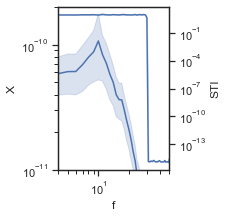

In [27]:
sns.set_theme(style='ticks')

fig,ax = plt.subplots(1,1,figsize=(2,3))

ax1 = ax.twinx()
sns.lineplot(data=capacity,x='f', y='X', ax=ax)

sns.lineplot(data=capacity, x='f', y='STI', ax=ax1)

ax.set_xlim(4,50)
ax.set_ylim(1e-11,2e-10)

for ax in fig.axes:
    ax.set_yscale('log')
    ax.set_xscale('log')

(1e-12, 2e-10)

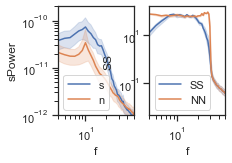

In [12]:
sns.set_theme(style='ticks')

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(3,2))

sns.lineplot(data=capacity,
             x='f', y='sPower', ax=ax1, label='s')

sns.lineplot(data=capacity,
             x='f', y='nPower', ax=ax1, label='n')

sns.lineplot(data=capacity,
             x='f', y='SS', ax=ax2, label='SS')

sns.lineplot(data=capacity,
             x='f', y='NN', ax=ax2, label='NN')

for ax in fig.axes:
    # ax.legend()
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim(4,50)

ax1.set_ylim(1e-12,2e-10)

In [1]:
sns.set_theme(style='ticks')

fig,ax1 = plt.subplots(1,1)

# sns.lineplot(data=capacity,
#              x='f', y='Hf', ax=ax1, hue='subject')

NameError: name 'sns' is not defined

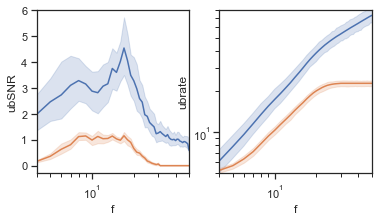

In [ ]:
sns.set_theme(style='ticks')

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(6,3))

sns.lineplot(data=capacity, x='f', y='ubrate', ax=ax1, legend=False)

sns.lineplot(data=capacity, x='f', y='lbSNR', ax=ax1,legend=False)

sns.lineplot(data=capacity, x='f', y='ubrate', ax=ax2, legend=False)

sns.lineplot(data=capacity, x='f', y='lbrate', ax=ax2,legend=False)

ax2.set_xlim(4,50)
ax2.set_ylim(5,80)
ax1.set_xlim(4,50)

# for ax in fig.axes:
ax2.set_yscale('log')
ax1.set_xscale('log')
ax2.set_xscale('log')